In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

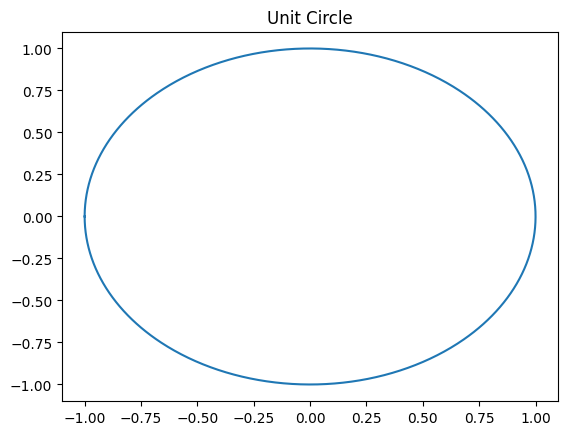

In [19]:
theta = np.linspace(-np.pi, np.pi, num=1000)
x_vals = np.cos(theta)
y_vals = np.sin(theta)

plt.plot(x_vals, y_vals)
plt.title('Unit Circle')
plt.show()

### Exercise

1. Create a Neural Network that accepts two inputs. $(x,y)$. This will be intended to predict the $\theta$ at $tan\theta = \frac{y}{x}$. Make sure that it's guaranteed to output from $[-\pi, \pi]$
2. Formulate a Loss Function using von Mises Distribution as stated in **Section 5.2**
3. Train the Neural Network from (1) using (2)
4. Train the Neural Network from (1) using Loss Function derived using Gaussian (Least Square Loss)
5. Compare the results of (3) and (4)

## Step 1

Create a Neural Network that accepts two inputs. $(x,y)$. This will be intended to predict the $\theta$ at $tan\theta = \frac{y}{x}$. Make sure that it's guaranteed to output from $[-\pi, \pi]$

### Guarantee that the final activation has a Domain of $[-\pi, \pi]$ 

Here we will be using $a[z] = \pi * tanh[z]$

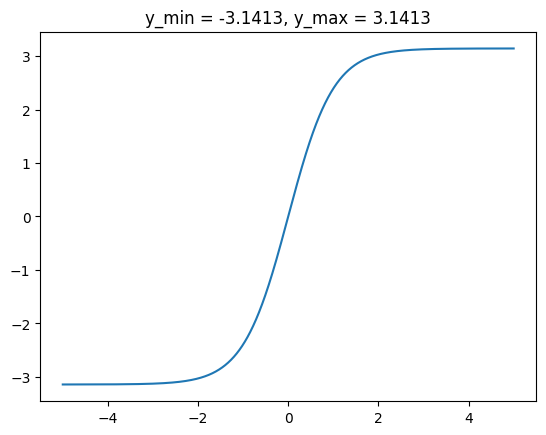

In [18]:
x_max = 5
x_range = jnp.linspace(-x_max, x_max, num=2000)
y_out = jnp.pi * jnp.tanh(x_range)

y_min = float(jnp.min(y_out))
y_max = float(jnp.max(y_out))

y_min = round(y_min, 4)
y_max = round(y_max, 4)

plt.plot(x_range, y_out)
plt.title(f'y_min = {y_min}, y_max = {y_max}')
plt.show()

In [20]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jacobian
from jax import random
import math
from jax.scipy.special import logsumexp
from jax.nn import sigmoid
import jax

# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (m, n)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(network_sizes, scale=1e-2):
  key =  random.PRNGKey(0)
  keys = random.split(key, len(network_sizes))
  return [
     random_layer_params(in_out[0], in_out[1], k, scale) for in_out, k in zip(network_sizes, keys)]

def display_params(params, params_name):
   print(f'{params_name} total num_layers = ', len(params))
   for level, param in enumerate(params, start=1):
      weight_shape = param[0].shape
      bias_shape = param[1].shape
      print(f'({level}) {params_name}_weights.shape = {weight_shape}, {params_name}_bias.shape = {bias_shape}')

In [21]:
def relu(x):
    return jnp.where(x >= 0, x, 0)

def mse(y_pred,y_target):
    return jnp.mean((y_pred - y_target) ** 2)

def cosine_loss(y_pred, y_target):
    return -jnp.sum(jnp.cos(y_target - y_pred))

def linear(W, x):
    return x @ W

def predict(params, X):
    activations = X 
    for w, b in params[:-1]:
        outputs = activations @ w + b
        activations = relu(outputs)
    
    final_w = params[-1][0]
    final_b = params[-1][1]

    logits = activations @ final_w + final_b
    return jnp.pi * jnp.tanh(logits)

@jit
def loss_von_mises_func(params, X_train, y_train):
  preds = predict(params, X_train)
  return cosine_loss(preds, y_train)

@jit
def loss_von_mises_func(params, X_train, y_train):
  preds = predict(params, X_train)
  return cosine_loss(preds, y_train)

In [ ]:
import numpy as np

def generate_data(num_sample):
  seed = np.random.randint(0, 1024)
  key =  jax.random.PRNGKey(seed)
  key, subkey = jax.random.split(key)
  X_train = jnp.linspace(-1.0, 1.0, num_sample).reshape(-1,1)
  return X_train

def update_weights(params, X, y, step_size):
  grads = grad(loss_func)(params, X, y)

  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

def train_network(params, num_sample, num_epochs, step_size, step_display, current_round):
  for curr_epoch in range(1, num_epochs + 1):
    X_train = generate_data(num_sample)

    loss = loss_func(params, X_train, X_train)
    params = update_weights(params, X_train, X_train, step_size)
    if curr_epoch % step_display == 0:
      print(f'[{curr_epoch}/{num_epochs}] Loss: {loss}')

  return params, current_round + 1

In [7]:
num_hidden = 10
network_sizes = [
    (2, num_hidden),
    (num_hidden, 1)
]

params = init_network_params(network_sizes)
display_params(params, 'parameters')

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
2024-02-10 04:24:09.804598: W pjrt_plugin/src/mps_client.cc:563] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Metal device set to: Apple M3 Max

systemMemory: 36.00 GB
maxCacheSize: 13.50 GB

parameters total num_layers =  2
(1) parameters_weights.shape = (2, 10), parameters_bias.shape = (10,)
(2) parameters_weights.shape = (10, 1), parameters_bias.shape = (1,)
